In [ ]:
%env DB_PATH=../../../data/db/srs.db
from db import *
from api.routers.rolls import get_roll
from sqlalchemy import insert, select
from lib.fit import get_sensor_data
from lib.signal import lowpass_filter
    
import pandas as pd

import numpy as np
from garmin_fit_sdk import Decoder, Stream
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
# from util import lowpass_filter
FIT_EPOCH_S = 631065600
DATA_PATH = '../../../data'

In [ ]:
with Session(engine) as session:
    roll = get_roll(6, session)

In [ ]:
fit = [f for f in roll.roll_files if f.type == 'fit'][0]
path = fit.uri.replace("%fit%/", f'{DATA_PATH}/virbs/')
stream = Stream.from_file(path)
decoder = Decoder(stream)
messages, errors = decoder.read(convert_datetimes_to_dates=False)
errors

In [ ]:
starts = [m for m in messages['camera_event_mesgs'] if m['camera_event_type'] == 'video_start']
if len(starts) != 1:
    raise ValueError(f"Found {len(starts)} video start events")
start = starts[0]
start_time = start['timestamp'] * 1000 + start['timestamp_ms']
start_time

In [ ]:
gps_mesgs = messages['gps_metadata_mesgs']
gps_raw = pd.DataFrame.from_records(gps_mesgs)
gps_data = gps_raw.copy()
gps_data['utc_timestamp'] = pd.to_datetime((gps_data.utc_timestamp + FIT_EPOCH_S) * 1e9)
gps_data.index = (gps_data.timestamp * 1000 + gps_data.timestamp_ms)
gps_data['timestamp'] = gps_data.index
gps_data.position_lat = gps_data.position_lat / 2**31 * 180
gps_data.position_long = gps_data.position_long / 2**31 * 180
gps_data

In [ ]:
# %timeit np.linalg.norm(np.array(gps_data.velocity.to_list()), axis=1)

In [ ]:
gps_data[['timestamp', 'position_lat', 'position_long']].head().to_dict(orient='list')

In [ ]:
px.line(gps_data.enhanced_speed)

In [ ]:
px.scatter(gps_data, x='position_long', y='position_lat', color='timestamp', size='enhanced_speed', size_max=10)

In [ ]:
import json
with open(f'../../../tmp/{path.split('/')[-1].replace(".fit", ".json")}', 'w') as f:
    json.dump(messages, f, indent=2, default=str)

In [ ]:
import orjson
def load_test():
    with open(f'../../../tmp/{path.split('/')[-1].replace(".fit", ".json")}') as f:
        json.load(f)
        
def load_test2():
    with open(f'../../../tmp/{path.split('/')[-1].replace(".fit", ".json")}') as f:
        orjson.loads(f.read())

In [ ]:
with open(f'../../../tmp/{path.split('/')[-1].replace(".fit", "_test.json")}', 'w') as f:
    json.dump(messages, f, default=str)

In [ ]:
%timeit load_test2()

# Geo

In [ ]:
import rasterio
from rasterio.plot import show
from pyproj import Transformer
import geopandas as gpd
import shapely
from shapely.geometry import Point
from shapely.ops import nearest_points

In [ ]:
elevation = rasterio.open(f'{DATA_PATH}/geo/output_USGS1m.tif')

In [ ]:
# show elevation data as image
elevation_data = elevation.read(1)
show(elevation_data, transform=elevation.transform, cmap='viridis')

In [ ]:
transformer = Transformer.from_crs("epsg:4326", elevation.crs)
locs = transformer.transform(gps_data.position_lat.values, gps_data.position_long.values)
# get ele

In [ ]:
point_list = [elevation.index(x, y) for x, y in zip(locs[0], locs[1])]
points = pd.DataFrame.from_records([{'col': p[1], 'row': p[0]} for p in point_list])
plt.imshow(elevation_data, cmap='viridis')
plt.scatter(x=points.col, y=points.row, c='red', s=1)

In [ ]:
points_tmp = pd.DataFrame.from_records([{'x': p[0], 'y': p[1]} for p in zip(locs[0], locs[1])])
fig, ax, = plt.subplots()
plt.scatter(x=points_tmp.x, y=points_tmp.y, c='red', s=1)
show(elevation_data, transform=elevation.transform, ax=ax, cmap='viridis')

In [ ]:
elevations = [e[0] for e in elevation.sample(zip(locs[0], locs[1]))]
len(elevations)

In [ ]:
gps_data['elevations'] = elevations
px.line(gps_data, y='elevations')

In [ ]:
# plot energy, enhanced_speed, and elevation with separate y axes
energy = 1/2 * (gps_data.enhanced_speed ** 2) + gps_data.elevations * 9.81

fig = go.Figure()

fig.add_trace(
    go.Scatter(x=gps_data.index / 1000.0, y=energy, name="energy (J/kg)", yaxis="y1")
)

fig.add_trace(
    go.Scatter(x=gps_data.index / 1000.0, y=gps_data.enhanced_speed, name="enhanced_speed (m/s)", yaxis="y2")
)

fig.add_trace(
    go.Scatter(x=gps_data.index / 1000.0, y=gps_data.elevations, name="elevation (m)", yaxis="y3")
)

fig.update_layout(
    xaxis=dict(domain=[0.15, 1]),
    yaxis=dict(title="energy (J/kg)"),
    yaxis2=dict(title="enhanced_speed (m/s)", 
                anchor="free", overlaying="y", side="left", position=0.05),
    yaxis3=dict(title="elevation (m)",
                anchor="x", overlaying="y", side="right")
)

fig.show()

In [ ]:
course = gpd.read_file(f'{DATA_PATH}/geo/course.kml').geometry
course.plot()

In [ ]:
fig, ax, = plt.subplots()
course.to_crs(elevation.crs).plot(ax=ax, color='red')
show(elevation_data, transform=elevation.transform, ax=ax, cmap='viridis')

In [ ]:
pos = gpd.GeoSeries(gpd.points_from_xy(gps_data.position_long, gps_data.position_lat))
# x = gps_data.iloc[1000].position_long
# y = gps_data.iloc[1000].position_lat
near = gpd.GeoSeries(nearest_points(course[0], pos.values)[0], crs="epsg:4326")
near.plot()

In [ ]:
near_points = near.to_crs(elevation.crs).apply(lambda p: elevation.index(p.x, p.y))
near_points = pd.DataFrame.from_records([{'col': p[0], 'row': p[1]} for p in near_points])
samples = elevation.sample(near.to_crs(elevation.crs).apply(lambda p: (p.x, p.y)))
gps_data['elevations'] = pd.Series([e[0] for e in samples], index=gps_data.index)

## 3D

In [ ]:
stride = 3
elevation_xyz = pd.DataFrame.from_records([
    {'y': i * stride, 'x': j * stride, 'elevation': e} 
    for j, row in enumerate(elevation_data[::stride])
        for i, e in enumerate(row[::stride])
])
elevation_xyz


In [ ]:
points.index

In [ ]:
fig = go.Figure(data=[go.Scatter3d(
    x=elevation_xyz.x,
    y=elevation_xyz.y,
    z=elevation_xyz.elevation,
    mode='markers',
    marker=dict(
        size=3,
        color=elevation_xyz.elevation,                
        colorscale='Viridis',   
        opacity=1
    ),
)])

# fig = go.Figure(data=[go.Mesh3d(
#     x=elevation_xyz.x,
#     y=elevation_xyz.y,
#     z=elevation_xyz.elevation,
#     color='gray',
# )])
max_e = elevation_xyz.elevation.max()
fig.update_layout(
    width=1000, 
    height=400,
    margin=dict(l=0, r=0, t=0, b=0),
    scene=dict(
        aspectmode='manual',
        aspectratio=dict(x=3, y=3, z=1),
        zaxis=dict(range=[max_e * 0.75, max_e * 1.1])
    )
)
fig.add_trace(go.Scatter3d(x=near_points.col, y=near_points.row, z=gps_data.elevations,
                           mode='markers', 
                           hovertext=gps_data.index[points.index] / 1000.0,
                           marker=dict(size=5, color=points.index, colorscale='Hot')))
fig.show()

## Sat

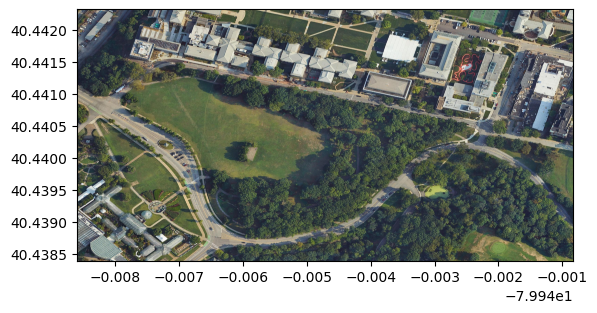

<Axes: >

In [86]:
sat = rasterio.open(f'{DATA_PATH}/geo/course_sat.tif')
sat_img = sat.read()
show(sat_img, transform=sat.transform)

<Axes: >

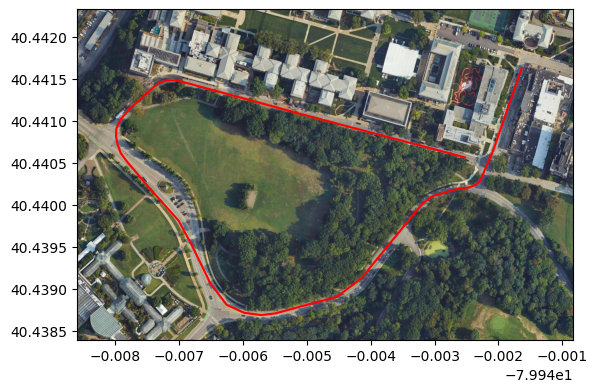

In [87]:
fig, ax, = plt.subplots()
show(sat_img, transform=sat.transform, ax=ax)
course.to_crs(sat.crs).plot(ax=ax, color='red')

In [ ]:
with rasterio.open('../../../tmp/course_sat.png', 'w', driver='PNG', 
                   height=sat_img.shape[1], width=sat_img.shape[2], 
                   count=3, dtype=sat_img.dtype) as dst:
    dst.write(sat_img)

In [ ]:
inv = ~sat.transform
import json
json.dumps(inv)

In [97]:
list(sat.bounds), sat.shape

([-79.948599138, 40.4383888, -79.940837694, 40.442326861], (4608, 6912))

(4608, 6912)

In [ ]:
hom_cords = pd.DataFrame(data=dict(lon=gps_data.position_long, lat=gps_data.position_lat, ))
hom_cords['z'] = 1
hom_cords.values[0]

In [ ]:
sat.index(-79.94146692, 40.4417369)

In [ ]:
np.array(inv).reshape(3, 3) @ hom_cords.values.T

In [ ]:
from PIL import Image

# Accel

In [ ]:
from scipy import signal, interpolate

In [ ]:
calibration_mesgs = messages['three_d_sensor_calibration_mesgs']
calibration_data = { m['sensor_type']: m for m in calibration_mesgs }
accel_cal = calibration_data['accelerometer']
accel_cal

In [ ]:
accel_raw, accel_data, fs = get_sensor_data(accel_cal, messages['accelerometer_data_mesgs'], {'x': 'accel_x', 'y': 'accel_y', 'z': 'accel_z'})
accel_data
# %timeit get_sensor_data(accel_cal, messages['accelerometer_data_mesgs'], {'x': 'accel_x', 'y': 'accel_y', 'z': 'accel_z'})

In [ ]:
px.line(accel_data.y)

In [ ]:
f, Pxx = signal.welch(accel_data.x.values, float(fs), nperseg=1024)
px.line(pd.DataFrame(index=f, data=dict(PSD=Pxx)))

In [ ]:
accel_data.index.to_series().diff().median()

In [ ]:
cs = interpolate.CubicSpline(accel_data.index, accel_data[['x', 'y', 'z']].values)
xs = np.arange((accel_data.index[0] - accel_data.index[0] % 100) + 100, accel_data.index[-1], 10)
interpolated = cs(xs)
accel_uniform = pd.DataFrame(interpolated, columns=['x', 'y', 'z'], index=xs)
accel_uniform

In [ ]:
decimation = 20
decimated = signal.decimate(accel_uniform.T, decimation)
accel_decimated = pd.DataFrame(decimated.T, columns=['x', 'y', 'z'], index=accel_uniform.index[::decimation])
px.line(accel_decimated.x)

In [ ]:
valid_min = max(accel_decimated.index[0], gps_data.index[0])
valid_min = valid_min - valid_min % 100 + 100

valid_max = min(accel_decimated.index[-1], gps_data.index[-1])
valid_max = valid_max - valid_max % 100 - 100

valid = accel_decimated.index[(accel_decimated.index >= valid_min) & (accel_decimated.index <= valid_max)]
a_interp = accel_decimated.loc[valid]
a_interp

In [ ]:
# v_data = pd.DataFrame(gps_data.velocity.to_list(), columns=['x', 'y', 'z'], index=gps_data.index)
v_data = pd.DataFrame.from_records(gps_data.velocity.apply(lambda v: (v[1], v[0], v[2])).to_list(), columns=['x', 'y', 'z'], index=gps_data.index)

In [ ]:
v_cs = interpolate.CubicSpline(v_data.index, v_data.values)
v_interp = pd.DataFrame(v_cs(valid), columns=['x', 'y', 'z'], index=valid)
v_interp

In [ ]:
accel_calc = v_cs.derivative()(valid) * (1000 / (valid[1] - valid[0]))
accel_calc = pd.DataFrame(accel_calc, columns=['x', 'y', 'z'], index=valid)

speed_interp = pd.Series(np.linalg.norm(v_interp, axis = 1), index=valid)
d_speed = v_interp.x * accel_calc.x + v_interp.y * accel_calc.y + accel_calc.z * v_interp.z / np.sqrt(v_interp.x ** 2 + v_interp.y ** 2)
px.line(d_speed)

In [ ]:
# remove duplicate points
gps_filtered = gps_data.loc[(gps_data.position_lat.shift(1) != gps_data.position_lat) | (gps_data.position_long.shift(1) != gps_data.position_long)]

interpolate_gps = interpolate.make_splprep([gps_filtered.position_lat.values, gps_filtered.position_long.values], u=gps_filtered.index.values)[0]

In [ ]:
(accel_data.index[-1] - accel_data.index[0]) // 10

## Heading

In [ ]:
# remove duplicate points
gps_filtered = gps_data.loc[(gps_data.position_lat.shift(1) != gps_data.position_lat) | (gps_data.position_long.shift(1) != gps_data.position_long)]

interpolate_gps = interpolate.make_splprep([gps_filtered.position_lat.values, gps_filtered.position_long.values], u=gps_filtered.index.values)[0]

In [ ]:
gps_interp = pd.DataFrame(interpolate_gps(valid).T, columns=['position_lat', 'position_long'], index=valid)

In [ ]:
v_filt = lowpass_filter(v_interp.T, 0.5, 1000/(v_interp.index[1] - v_interp.index[0])).T
v_filt = pd.DataFrame(v_filt, columns=['x', 'y', 'z'], index=valid)

In [ ]:
px.line(v_filt)

In [ ]:
filt_cs = interpolate.CubicSpline(v_filt.index, v_filt.values)

In [ ]:
v_x = filt_cs(valid)[:, 0]
v_y = filt_cs(valid)[:, 1]
a_x = filt_cs.derivative()(valid)[:, 0]
a_y = filt_cs.derivative()(valid)[:, 1]

curvature = (v_x * a_y - v_y * a_x) / np.pow(v_x **2 + v_y ** 2, 3/2)
curvature = pd.Series(data=curvature, index=valid)
px.line(curvature.iloc[v_x **2 + v_y ** 2 > 2])

In [ ]:
accel_filt = filt_cs.derivative()(valid) * (1000)
accel_filt = pd.DataFrame(accel_filt, columns=['x', 'y', 'z'], index=valid)

speed_filt = pd.Series(np.linalg.norm(v_filt, axis = 1), index=valid)
d_speed = v_filt.x * accel_filt.x + v_filt.y * accel_filt.y +  v_filt.z * accel_filt.z/ np.sqrt(v_filt.x ** 2 + v_filt.y ** 2 + v_filt.z ** 2)
px.line(d_speed + v_filt.z * 9.81)

In [ ]:
px.line(speed_filt)

In [ ]:
px.line(v_filt)

In [ ]:
heading = gps_data.heading[gps_data.enhanced_speed > 2]
# heading_cs = interpolate.CubicSpline(heading.index, heading.values)
# heading_interp = pd.Series(heading_cs(valid), index=valid)
# px.line(heading_interp)
offsets = np.array([heading.shift(1) - heading, heading.shift(1) - heading - 360, heading.shift(1) - heading + 360])
mins = np.argmin(np.abs(offsets), axis=0)
heading_diffs = pd.Series(offsets[mins, np.arange(len(mins))], index=heading.index).iloc[1:]
# px.line(lowpass_filter(heading_diffs, 2, 10))
omega = (heading_diffs * (np.pi / 180)) / (heading_diffs.index.diff() / 1000)
px.line(omega)

In [ ]:
px.line(omega * gps_data.enhanced_speed.loc[omega.index])

In [ ]:
fs_heading = 1000 / heading_diffs.index.to_series().diff().median()
f_heading, Pxx_heading = signal.welch(heading_diffs.values, float(fs_heading), nperseg=1024)

In [ ]:
heading_diffs_filt = lowpass_filter(heading_diffs, 2, 10)
px.line(pd.Series(heading_diffs_filt, index=heading_diffs.index))

In [ ]:
px.line(pd.Series(data=Pxx_heading, index=f_heading))

In [ ]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Plot energy vs heading changes
fig.add_trace(
    go.Scatter(x=energy.index / 1000.0, y=energy, name="energy (J/kg)"),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(x=heading_diffs.index / 1000.0, y=heading_diffs, name="heading change (deg)"),
    secondary_y=True,
)
fig.show()

# Gryo, Mag

In [ ]:
from scipy import signal

In [ ]:
calibration_mesgs = messages['three_d_sensor_calibration_mesgs']
calibration_data = { m['sensor_type']: m for m in calibration_mesgs }
gyro_cal = calibration_data['gyroscope']
gyro_cal

In [ ]:
gyro_raw, gyro_data, gyro_fs = get_sensor_data(gyro_cal, messages['gyroscope_data_mesgs'], {'x': 'gyro_x', 'y': 'gyro_y', 'z': 'gyro_z'})
gyro_data

In [ ]:
px.line(gyro_data.x)

In [ ]:
decimation = 20
gyro_decimated = -1 * signal.decimate(gyro_data.z, decimation).T
gyro_decimated = pd.Series(gyro_decimated, index=gyro_data.index[::decimation])
px.line(gyro_decimated)

In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=gyro_decimated.index / 1000.0, y=gyro_decimated, name="gyro_z (rad/s)", yaxis="y1")
)

fig.add_trace(
    go.Scatter(x=heading_diffs.index / 1000.0, y=heading_diffs, name="heading_diffs (deg)", yaxis="y2")
)

fig.update_layout(
    xaxis=dict(title="time (s)"),
    yaxis=dict(title="gyro_z (rad/s)"),
    yaxis2=dict(title="heading_diffs (deg)", overlaying="y", side="right")
)

fig.show()

In [ ]:
px.line()

In [ ]:
f_gyro, Pxx_gyro = signal.welch(gyro_data.z.values, float(gyro_fs), nperseg=1024)
px.line(pd.DataFrame(index=f_gyro, data=dict(PSD=Pxx_gyro)))

## Magnetometer

In [ ]:
mag_cal = calibration_data['compass']
mag_cal

In [ ]:
mag_raw, mag_data, mag_fs = get_sensor_data(mag_cal, messages['magnetometer_data_mesgs'], {'x': 'mag_x', 'y': 'mag_y', 'z': 'mag_z'})
mag_data

In [ ]:
mag_decimated = signal.decimate(mag_data[['x', 'y', 'z']].T, 20).T
px.line(mag_decimated)

In [ ]:
mag_heading = 180 - (180 * np.arctan2(mag_decimated[:, 1], mag_decimated[:, 0]))
mag_heading = pd.Series(mag_heading, index=mag_data.index[::10])
px.line(mag_heading)

In [ ]:
px.line(gps_data.heading)